In [1]:
%matplotlib inline
# Dependencies
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats, mean
import time
from dateutil.relativedelta import relativedelta
from pandas.plotting import table 

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
# Create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [9]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#-----------------------------------------------------------------------------------------

In [12]:
# Figure out the last date in the measurement table
last_measurement_record = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_measurement_year = int(last_measurement_record[0][:4])
last_measurement_month = int(last_measurement_record[0][5:7])
last_measurement_day = int(last_measurement_record[0][8:10])
print(last_measurement_year)
print(last_measurement_month)
print(last_measurement_day)



2017
8
23


In [13]:
date_year_ago = dt.date(last_measurement_year,\
                        last_measurement_month,\
                        last_measurement_day) - relativedelta(years=1)
print(date_year_ago)

2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
precipitation_12_months_query = session.query(Measurement.date,Measurement.prcp).\
                                       filter(Measurement.date >= date_year_ago).\
                                     order_by(Measurement.date)



In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_12_months_df = pd.read_sql_query(precipitation_12_months_query.statement,session.bind)
precipitation_12_months_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_12_months_df = precipitation_12_months_df.sort_values(by='date',ascending=True)
precipitation_12_months_df.head(30)


,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,1.45
2016-08-24,2.15


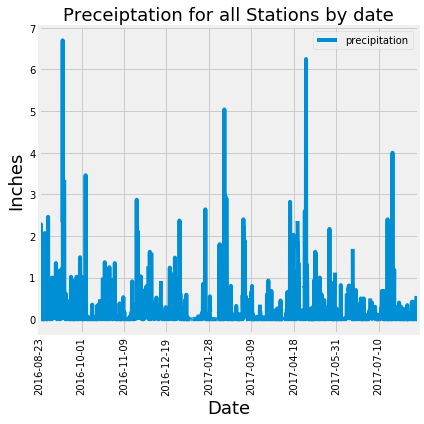

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_12_months_df.plot.line(figsize=(6,6))
plt.ylabel('Inches',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.title('Preceiptation for all Stations by date',fontsize=18)
plt.xticks(rotation=90)
plt.legend(['precipitation'])
plt.tight_layout()
plt.savefig('Images/precipitation.png')
plt.show()


In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
describe_df = precipitation_12_months_df.describe()
describe_df

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


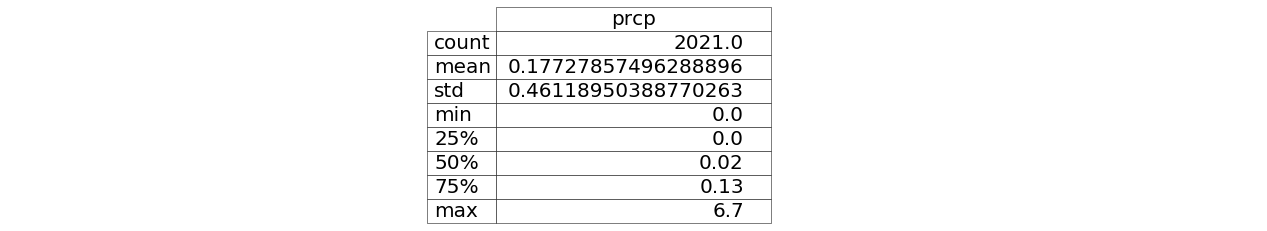

In [18]:
# Create a figure of the dataframe in order to output to a png file
fig, ax = plt.subplots(figsize=(20,4)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, describe_df, loc='center', colWidths=[0.11]*len(describe_df.columns))  
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(20) # if ++fontsize is necessary ++colWidths
tabla.scale(2,2) # change size table

# Save the describe data to describe.png
plt.savefig('Images/describe.png', transparent=True)

In [19]:
# Design a query to show how many stations are available in this dataset?
no_stations = session.query(Station.station).count()
print(f' There are {no_stations} stations in the station table')

no_measurement_stations = session.query(Measurement.station).distinct().count()
print(f' There are {no_measurement_stations} distinct stations in the measurement table')

 There are 9 stations in the station table
 There are 9 distinct stations in the measurement table


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.station).desc()).all()

# Output the results of the count query
print('The Most Active Stations in Descending Order')
print('--------------------------------------------')
print('  Station   Count')
print('----------- -----')
for station,station_count in most_active_stations:
    print(station,str(station_count).rjust(5,' '))


The Most Active Stations in Descending Order
--------------------------------------------
  Station   Count
----------- -----
USC00519281  2772
USC00519397  2724
USC00513117  2709
USC00519523  2669
USC00516128  2612
USC00514830  2202
USC00511918  1979
USC00517948  1372
USC00518838   511


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#--------------------------------------------------------------------------------------------

In [22]:
# Get the most active station ID
most_active_station = session.query(Measurement.station).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.station).desc()).first()[0]
print(f'The most active station ID is {most_active_station}')

The most active station ID is USC00519281


In [23]:
# Calculate the maximum temperature for the most active station
max_temp_for_most_active_station = session.query(func.max(Measurement.tobs)).\
                            filter_by(station= most_active_station).all()[0][0]
print(f'The maximum temperature for station {most_active_station} is {max_temp_for_most_active_station}')

The maximum temperature for station USC00519281 is 85.0


In [24]:
# Calculate the minimum temperature for the most active station
min_temp_for_most_active_station = session.query(func.min(Measurement.tobs)).\
                            filter_by(station= most_active_station).all()[0][0]
print(f'The minimum temperature for station {most_active_station} is {max_temp_for_most_active_station}')

The minimum temperature for station USC00519281 is 85.0


In [25]:
# Calculate the average temperature for the most active station
avg_temp_for_most_active_station = round(session.query(func.avg(Measurement.tobs)).\
                            filter_by(station= most_active_station).all()[0][0],2)
print(f'The average temperature for station {most_active_station} is {avg_temp_for_most_active_station}')

The average temperature for station USC00519281 is 71.66


In [26]:
# Place the data into a dataframe
most_active_summary_info = {"Most Active Station ID": most_active_station,
                                       "Most Active Station Max Temp": [max_temp_for_most_active_station],
                                       "Most Active Station Min Temp": [min_temp_for_most_active_station],
                                       "Most Active Station Avg Temp": [avg_temp_for_most_active_station]}

most_active_station_df = pd.DataFrame(most_active_summary_info)
most_active_station_df

,Most Active Station ID,Most Active Station Max Temp,Most Active Station Min Temp,Most Active Station Avg Temp
0,USC00519281,85.0,54.0,71.66


In [27]:
# Calculate the minimum temperature per station
temp_by_station = session.query(Measurement.station, \
                         func.count(Measurement.station), \
                           func.max(Measurement.tobs), \
                           func.min(Measurement.tobs), \
                           func.avg(Measurement.tobs)).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.station).desc()).all()
print('The maximum, minimum, & average temperature per station in most active descending order')
print('---------------------------------------------------------------------------------------')
print('  Station   Count Max  Min   Avg')
print('----------- ----- ---- ---- -----')
for station,station_count,station_max,station_min,station_avg in temp_by_station:
    print(station,str(station_count).rjust(5,' '),station_max,station_min,round(station_avg,2))

The maximum, minimum, & average temperature per station in most active descending order
---------------------------------------------------------------------------------------
  Station   Count Max  Min   Avg
----------- ----- ---- ---- -----
USC00519281  2772 85.0 54.0 71.66
USC00519397  2724 87.0 56.0 74.55
USC00513117  2709 85.0 59.0 72.69
USC00519523  2669 85.0 56.0 74.54
USC00516128  2612 84.0 58.0 70.92
USC00514830  2202 85.0 58.0 74.87
USC00511918  1979 87.0 53.0 71.62
USC00517948  1372 87.0 58.0 74.68
USC00518838   511 83.0 58.0 72.72


In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#--------------------------------------------------------------------------------------------------------------

In [29]:
# Figure out the last date in the measurement table for the most active station
most_active_last_measurement_record = session.query(Measurement.date).filter_by(station= most_active_station).order_by(Measurement.date.desc()).first()

most_active_last_measurement_year = int(most_active_last_measurement_record[0][:4])
most_active_last_measurement_month = int(most_active_last_measurement_record[0][5:7])
most_active_last_measurement_day = int(most_active_last_measurement_record[0][8:10])

print(most_active_last_measurement_year)
print(most_active_last_measurement_month)
print(most_active_last_measurement_day)

2017
8
18


In [30]:
most_active_date_year_ago = dt.date(most_active_last_measurement_year,\
                                    most_active_last_measurement_month,\
                                    most_active_last_measurement_day) - relativedelta(years=1)
print(most_active_date_year_ago)

2016-08-18


In [31]:
most_active_station_data_query = session.query(Measurement.date,Measurement.tobs).\
                                        filter(Measurement.station== most_active_station,\
                                               Measurement.date >= most_active_date_year_ago)
most_active_station_data_query

In [32]:
# Save the query results as a Pandas DataFrame and set the index to the date column
most_active_precipitation_12_months_df = pd.read_sql_query(most_active_station_data_query.statement,session.bind)
most_active_precipitation_12_months_df.set_index('date', inplace=True)

# Sort the dataframe by date
most_active_precipitation_12_months_df = most_active_precipitation_12_months_df.sort_values(by='date',ascending=True)
most_active_precipitation_12_months_df.head(30)


,tobs
date,
2016-08-18,80.0
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0


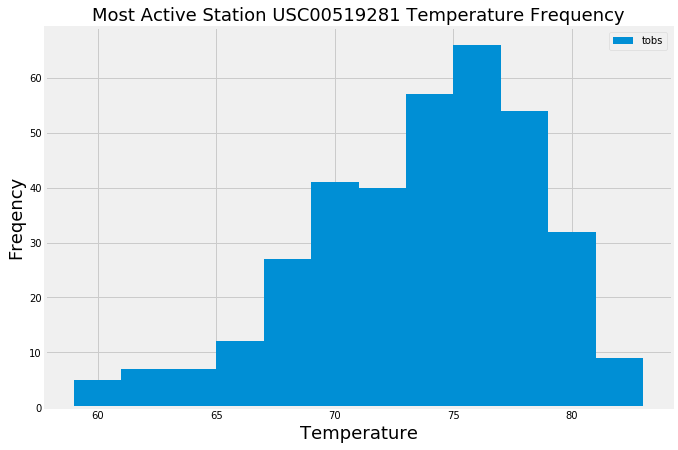

In [33]:
# Use Pandas Plotting with Matplotlib to plot the data
no_bins = 12
most_active_precipitation_12_months_df.plot.hist(bins=no_bins,figsize=(10,7))
plt.ylabel('Freqency',fontsize=18)
plt.xlabel('Temperature',fontsize=18)
plt.title(f'Most Active Station {most_active_station} Temperature Frequency',fontsize=18)
# plt.xticks(rotation=90)

# plt.tight_laout()
plt.savefig('Images/station-histogram.png')
plt.show()


## Bonus Challenge Assignment

### Temperature Analysis I

In [34]:
# Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the 
# temperature in, for example, June and December?

# Identify the average temperature in June at all stations across all available years in the dataset. 
# Do the same for December temperature.

# Use the t-test to determine whether the difference in the means, 
# if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [35]:
june_temps = session.query(Measurement.tobs).\
                    filter(func.strftime("%m", Measurement.date) == "06").all()
december_temps = session.query(Measurement.tobs).\
                    filter(func.strftime("%m", Measurement.date) == "12").all()

june_temps_list = list(np.ravel(june_temps))
december_temps_list = list(np.ravel(december_temps))

june_average = round(mean(june_temps_list),2)
december_average = round(mean(december_temps_list),2)

print(f'The average June Temperature is {june_average}')
print(f'The average December Temperature is {december_average}')

The average June Temperature is 74.94
The average December Temperature is 71.04


Per the Socratic website:
    
Paired means that both samples consist of the same test subjects. A paired t-test is equivalent to a one-sample t-test.

Unpaired means that both samples consist of distinct test subjects. An unpaired t-test is equivalent to a two-sample t-test.

# Therefore since June and December are not the same  we need to perform an Unpaired t-test.

In [36]:
# Perform unpaired (independent) t-test
stats.ttest_ind(june_temps_list, december_temps_list, equal_var=False)

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

Null Hypothosis = There is no significant difference between the June and December temperatures
Alternative Hypothosis = There is significant difference between June and December temperatures

# Since the P value is very close to zero this indicates strong evidence against the null hypothisis, so it should be rejected.  



### Temperature Analysis II

In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [38]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# ----------------------------------------------------------------------------------

In [39]:
# Our vacation is set to 12/20/2016 - 12/31/2016  so we want
# to look at the temperatures for the previous year
start_trip = dt.date(2016,12,20)
end_trip = dt.date(2016,12,31)

# Calculate the dates a year back
analysis_start_date = start_trip - relativedelta(years=1)
analysis_end_date = end_trip - relativedelta(years=1)

# Output the dates
print(start_trip,end_trip,analysis_start_date,analysis_end_date)

2016-12-20 2016-12-31 2015-12-20 2015-12-31


In [40]:
# Get the temperature max,min and average for the trip dates
trip_min, trip_avg, trip_max = calc_temps(analysis_start_date,analysis_end_date)[0]

# Output the information
print(f'Our trip is scheduled for {start_trip} to {end_trip}:')
print(f'We are using the previous year to compare {analysis_start_date} to {analysis_end_date}')
print(f'Maximum Temperature = {trip_max}')
print(f'Minimum Temperature = {trip_min}')
print(f'Averge Temperature  = {round(trip_avg,2)}')

Our trip is scheduled for 2016-12-20 to 2016-12-31:
We are using the previous year to compare 2015-12-20 to 2015-12-31
Maximum Temperature = 79.0
Minimum Temperature = 67.0
Averge Temperature  = 73.21


In [41]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# -----------------------------------------------------------------|

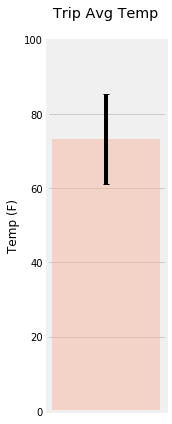

In [42]:
# Setup the x and y axis
x_axis=np.arange(1)
y_axis = trip_avg

# Setup a variable for the difference between the max and min
error = trip_max - trip_min

# Create the figure
fig, ax = plt.subplots(figsize=(2.5,6))
ax.bar(x_axis, y_axis, yerr=error, align='center', alpha=0.5, ecolor='black', color='#f7b79f', capsize=3)

# Setup the x and y labels and ticks
ax.set_ylabel('Temp (F)')
ax.set_yticks([0,20,40,60,80,100])
ax.set_xticks([])
ax.set_title('Trip Avg Temp\n')

# Setup the grids
ax.xaxis.grid(False)
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('Images/temperature.png')
plt.show()

### Daily Rainfall Average

In [43]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

temp_by_station = session.query(*sel).\
                                filter(Measurement.date >= analysis_start_date,
                                     Measurement.date <= analysis_end_date,
                                    Measurement.station == Station.station).\
                            group_by(Measurement.station).\
                            order_by(func.sum(Measurement.prcp).desc()).all()

temp_by_station_df = pd.DataFrame(temp_by_station, columns=["Station", "Name", "Latitude", "Longitude", "Elevation", "Total Precipitation"])
temp_by_station_df['Total Precipitation'] = temp_by_station_df['Total Precipitation'].fillna(0)
temp_by_station_df


,Station,Name,Latitude,Longitude,Elevation,Total Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,6.34
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,3.03
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.91
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.96
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.50
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.45
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00


In [44]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [45]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# ---------------------------------------------------------------

In [46]:
# Set the start and end date of the trip
start_trip = dt.date(2016,12,20)
end_trip = dt.date(2016,12,31)

# Use the start and end date to create a range of dates
date_range = pd.date_range(start=start_trip, end=end_trip)

# Stip off the year and save a list of %m-%d strings
month_day = []
for single_date in date_range:
    month_day.append(single_date.strftime("%m-%d"))


# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for single_date in month_day:
    normals.append(daily_normals(single_date))

# Output the normals information
normals

[[(65.0, 72.91304347826087, 81.0)],
 [(67.0, 72.13953488372093, 78.0)],
 [(67.0, 71.1304347826087, 77.0)],
 [(61.0, 70.34693877551021, 78.0)],
 [(62.0, 70.0625, 78.0)],
 [(60.0, 71.75, 79.0)],
 [(63.0, 71.44680851063829, 77.0)],
 [(62.0, 71.91666666666667, 79.0)],
 [(62.0, 70.52083333333333, 77.0)],
 [(57.0, 70.29166666666667, 78.0)],
 [(63.0, 69.86363636363636, 76.0)],
 [(56.0, 68.27906976744185, 77.0)]]

In [47]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

# Create lists for min, max, avg
trip_dates_min = []
trip_dates_max = []
trip_dates_avg = []

# Update the normals information into the min, max, and avg lists
for index, single_date in enumerate(month_day):
    for min_value, avg_value, max_value in normals[index]:
        trip_dates_min.append(min_value)
        trip_dates_avg.append(avg_value)
        trip_dates_max.append(max_value)

# Create a datafr
trip_dates_df = pd.DataFrame({
                              "trip_dates": date_range,
                              "tmin": trip_dates_min,
                              "tavg": trip_dates_avg,
                              "tmax": trip_dates_max
                             })

# Set the index to trip_days
trip_dates_df.set_index('trip_dates',inplace = True)

# Show the data
trip_dates_df

,tmin,tavg,tmax
trip_dates,,,
2016-12-20,65.0,72.913043,81.0
2016-12-21,67.0,72.139535,78.0
2016-12-22,67.0,71.130435,77.0
2016-12-23,61.0,70.346939,78.0
2016-12-24,62.0,70.062500,78.0
2016-12-25,60.0,71.750000,79.0
2016-12-26,63.0,71.446809,77.0
2016-12-27,62.0,71.916667,79.0
2016-12-28,62.0,70.520833,77.0


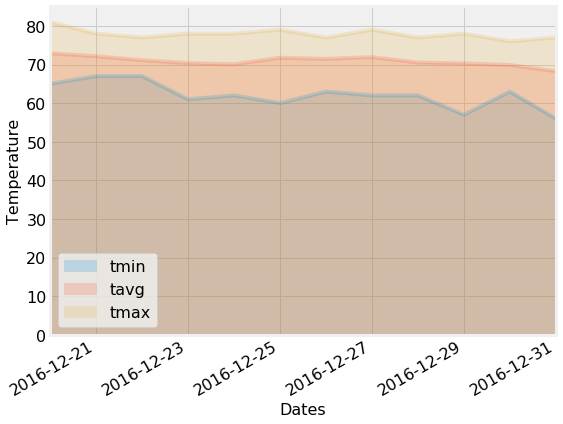

In [48]:
# Plot the daily normals as an area plot with `stacked=False`
trip_dates_df.plot.area(stacked=False, x_compat=True, alpha=.2,figsize=(8,6))

# Setup the lavels
plt.ylabel('Temperature',fontsize=16)
plt.xlabel('Dates',fontsize=16)

# Set the ticks label size
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

# Setup the legend
plt.legend(loc='best', prop={'size': 16})

# Adjust so that the entire chart will be saved correctly
plt.subplots_adjust(left=0.20, bottom=0.40, right=None, top=None, wspace=0.2, hspace=0)

plt.tight_layout()

# Save the figure to daily-normals.png
plt.savefig('Images/daily-normals.png')

# Show the chart
plt.show()
